In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('cleaned_loan_data.csv')
print("Dataset Loaded:")
print(data.head())

Dataset Loaded:
   loan_id  no_of_dependents     education self_employed  income_annum  \
0        1                 2      Graduate            No       9600000   
1        2                 0  Not Graduate           Yes       4100000   
2        3                 3      Graduate            No       9100000   
3        4                 3      Graduate            No       8200000   
4        5                 5  Not Graduate           Yes       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000          8          467                  18200000   
4     24200000         20          382                  12400000   

   commercial_assets_value  luxury_assets_value  bank_asset_value loan_status  
0                 17600000             22700000   

In [ ]:
data.columns = data.columns.str.strip()

In [4]:
data = data.drop('loan_id', axis=1)

In [5]:
print("\nColumn Names after stripping spaces:")
print(data.columns)


Column Names after stripping spaces:
Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')


In [ ]:
data['loan_status'] = data['loan_status'].map({'Approved': 1, 'Rejected': 0})

data['education'] = data['education'].map({'Graduate': 1, 'Not Graduate': 0})
data['self_employed'] = data['self_employed'].map({'Yes': 1, 'No': 0})

In [7]:
print("\nUnique values in loan_status after encoding:", data['loan_status'].unique())
print("Unique values in education after encoding:", data['education'].unique())
print("Unique values in self_employed after encoding:", data['self_employed'].unique())


Unique values in loan_status after encoding: [1 0]
Unique values in education after encoding: [1 0]
Unique values in self_employed after encoding: [0 1]


In [8]:
# Spliting
X = data.drop('loan_status', axis=1)
y = data['loan_status']

# Split into Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
missing_loan_status_count = data['loan_status'].isna().sum()
print(f"\nNumber of missing values in 'loan_status': {missing_loan_status_count}")

# Print the count of Rejected and Approved loans
print("\nCount of Rejected and Approved loans:")
print(data['loan_status'].value_counts())


Number of missing values in 'loan_status': 0

Count of Rejected and Approved loans:
loan_status
1    2656
0    1613
Name: count, dtype: int64


In [10]:
# Train the Model
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


Model Evaluation:
Accuracy: 0.9824355971896955
Precision: 0.9833024118738405
Recall: 0.9888059701492538
F1-score: 0.986046511627907


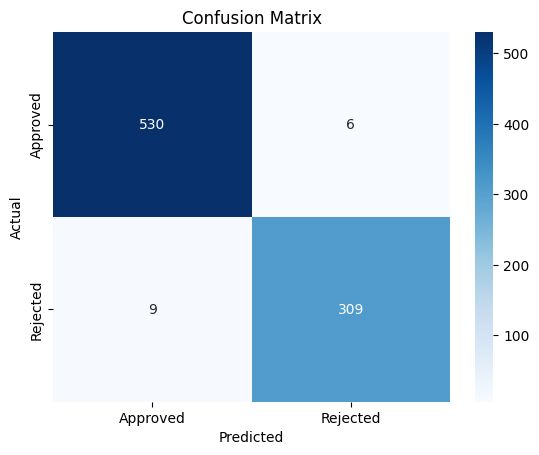

In [11]:
# Evaluate the Model
y_pred = model.predict(X_test)

print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Approved', 'Rejected'], yticklabels=['Approved', 'Rejected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Optimize the Model
# Hyperparameter Tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)

# Retrain with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)
print("\nOptimized Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))


Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

Optimized Model Evaluation:
Accuracy: 0.9754098360655737


In [15]:
# Save the Model
joblib.dump(best_model, 'credit_risk_model.pkl')
print("\nModel saved as 'credit_risk_model.pkl")


Model saved as 'credit_risk_model.pkl


In [14]:
# Test the model with new data
loaded_model = joblib.load('credit_risk_model.pkl')

new_data = pd.DataFrame({
    'no_of_dependents': [2],
    'education': [1],  # Graduate
    'self_employed': [0],  # No
    'income_annum': [9600000],
    'loan_amount': [29900000],
    'loan_term': [12],
    'cibil_score': [778],
    'residential_assets_value': [2400000],
    'commercial_assets_value': [17600000],
    'luxury_assets_value': [22700000],
    'bank_asset_value': [8000000]
})

# Ensure New Data Has the Same Columns as Training Data
missing_cols = set(X_train.columns) - set(new_data.columns)
for col in missing_cols:
    new_data[col] = 0
new_data = new_data[X_train.columns]

prediction = loaded_model.predict(new_data)
print("\nPrediction for New Data:", "Approved" if prediction[0] == 1 else "Rejected")


Prediction for New Data: Approved
